In [40]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


data = pd.read_csv('../data/transformed_data/all_time_series.csv', index_col=0)
# add index 
index_data = pd.read_csv('../data/transformed_data/spreads_df_norm.csv', index_col=0)

In [41]:
# merge data with index_data column average
data = data.merge(index_data['average'], left_index=True, right_index=True)
# rename col average to index
data.rename(columns={'average': 'pos_news_index'}, inplace=True)

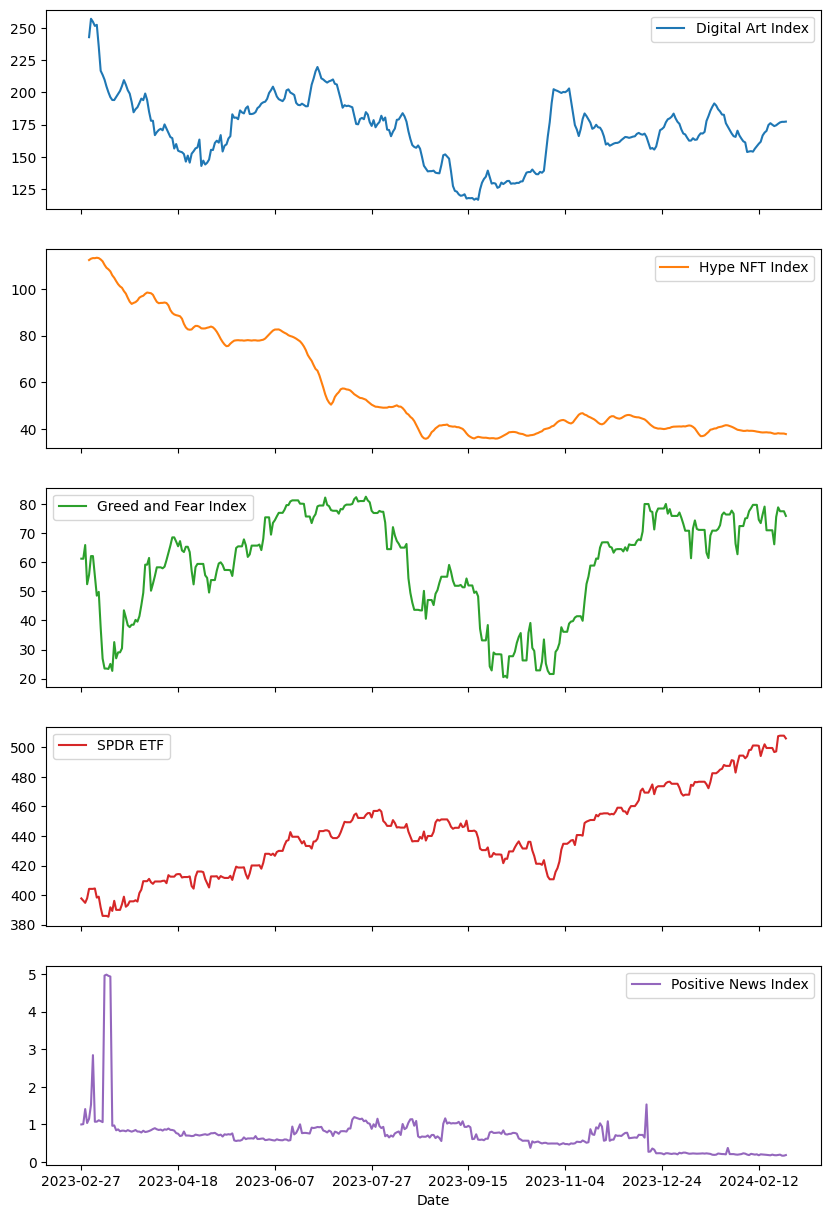

In [42]:
# plot data
data.columns = ['Digital Art Index', 'Hype NFT Index', 'Greed and Fear Index', 'SPDR ETF','Positive News Index']
data.plot(subplots=True, figsize=(10, 15), )
# save plot
plt.savefig('../plots/time_series.png')



In [43]:
# define dickey fuller test function
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput['p-value']    


In [44]:
# test for stationarity
for column in data.columns:
    print(f'Testing stationarity for {column}')
    result = test_stationarity(data[column].dropna())
    print(f'p-value: {result} for {column}')

# new column for difference test stationarity
for column in data.columns:
    data[column + '_diff'] = data[column].diff().dropna()
    print(f'Testing stationarity for {column} first difference')
    result = test_stationarity(data[column + '_diff'].dropna())
    print(f'p-value: {result} for {column} first difference')



Testing stationarity for Digital Art Index
Results of Dickey-Fuller Test:
p-value: 0.12856945245162554 for Digital Art Index
Testing stationarity for Hype NFT Index
Results of Dickey-Fuller Test:
p-value: 0.11822801825087004 for Hype NFT Index
Testing stationarity for Greed and Fear Index
Results of Dickey-Fuller Test:
p-value: 0.35598711215620044 for Greed and Fear Index
Testing stationarity for SPDR ETF
Results of Dickey-Fuller Test:
p-value: 0.9399574904509204 for SPDR ETF
Testing stationarity for Positive News Index
Results of Dickey-Fuller Test:
p-value: 2.3238890609976768e-07 for Positive News Index
Testing stationarity for Digital Art Index first difference
Results of Dickey-Fuller Test:
p-value: 9.601295593312271e-05 for Digital Art Index first difference
Testing stationarity for Hype NFT Index first difference
Results of Dickey-Fuller Test:
p-value: 0.001039806148814765 for Hype NFT Index first difference
Testing stationarity for Greed and Fear Index first difference
Results o

In [45]:
data.columns

Index(['Digital Art Index', 'Hype NFT Index', 'Greed and Fear Index',
       'SPDR ETF', 'Positive News Index', 'Digital Art Index_diff',
       'Hype NFT Index_diff', 'Greed and Fear Index_diff', 'SPDR ETF_diff',
       'Positive News Index_diff'],
      dtype='object')

In [47]:
import statsmodels.api as sm

# Select appropriate columns
selected_columns = [ 'Digital Art Index_diff', 'Hype NFT Index_diff',
       'Greed and Fear Index_diff', 'SPDR ETF_diff','Positive News Index'] 
data_svar = data[selected_columns]

# drop all NaN values (shouldn't be present)
data_svar = data_svar.dropna()

# determine optimal lag
model = sm.tsa.VAR(data_svar)
lag_results = model.select_order(15).summary()

# plot lag results
lag_results

/Users/simon/Documents/Uni/Statistic/Semester 6/svar-causal/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,3.414,3.469,30.37,3.436
1,0.5757,0.9099*,1.778,0.7088
2,0.3719,0.9847,1.451,0.6159*
3,0.3566,1.248,1.429,0.7115
4,0.4352,1.605,1.546,0.9010
5,0.3549,1.803,1.428,0.9316
6,0.1967,1.924,1.220,0.8844
7,0.2174,2.223,1.248,1.016
8,0.2488,2.533,1.290,1.158
9,0.2611,2.823,1.309,1.282


In [83]:
import numpy as np
import statsmodels.api as sm

data_svar = data[['Digital Art Index_diff', 'Hype NFT Index_diff',
       'Greed and Fear Index_diff', 'SPDR ETF_diff','Positive News Index_diff']]
data_svar.dropna(inplace=True)

A = np.array([
    [1, 'E', 'E', 0, 'E'],  # Digital Art 
    ['E', 1, 'E', 0, 'E'],  # Hype Index
    ['E', 0, 1, 'E', 0],  # Greed and Fear Index 
    [0, 0, 'E', 1, 0],  # SPDR ETF 
    [0, 0, 'E', 0, 1]   # Positive News Index 
])
# Create the SVAR model instance
model = sm.tsa.SVAR(data_svar, svar_type='A', A=A)

# Fit the model
results = model.fit(maxlags=11)

results.k_exog_user = 0 # https://github.com/statsmodels/statsmodels/issues/8025
# Print the summary
results.summary()

/var/folders/rp/1xxr_95d09j_t6cjf0dp36bh0000gn/T/ipykernel_84930/4051847060.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_svar.dropna(inplace=True)
/Users/simon/Documents/Uni/Statistic/Semester 6/svar-causal/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/simon/Documents/Uni/Statistic/Semester 6/svar-causal/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Thu, 29, Feb, 2024
Time:                     17:09:21
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    4.24846
Nobs:                     349.000    HQIC:                   2.38678
Log likelihood:          -2397.69    FPE:                    3.22057
AIC:                      1.15557    Det(Omega_mle):         1.53033
--------------------------------------------------------------------
Results for equation Digital Art Index_diff
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 0.195119         0.218710            0.892           0.372
L1.Digital Art Index_diff             0.279704         0.056747            4

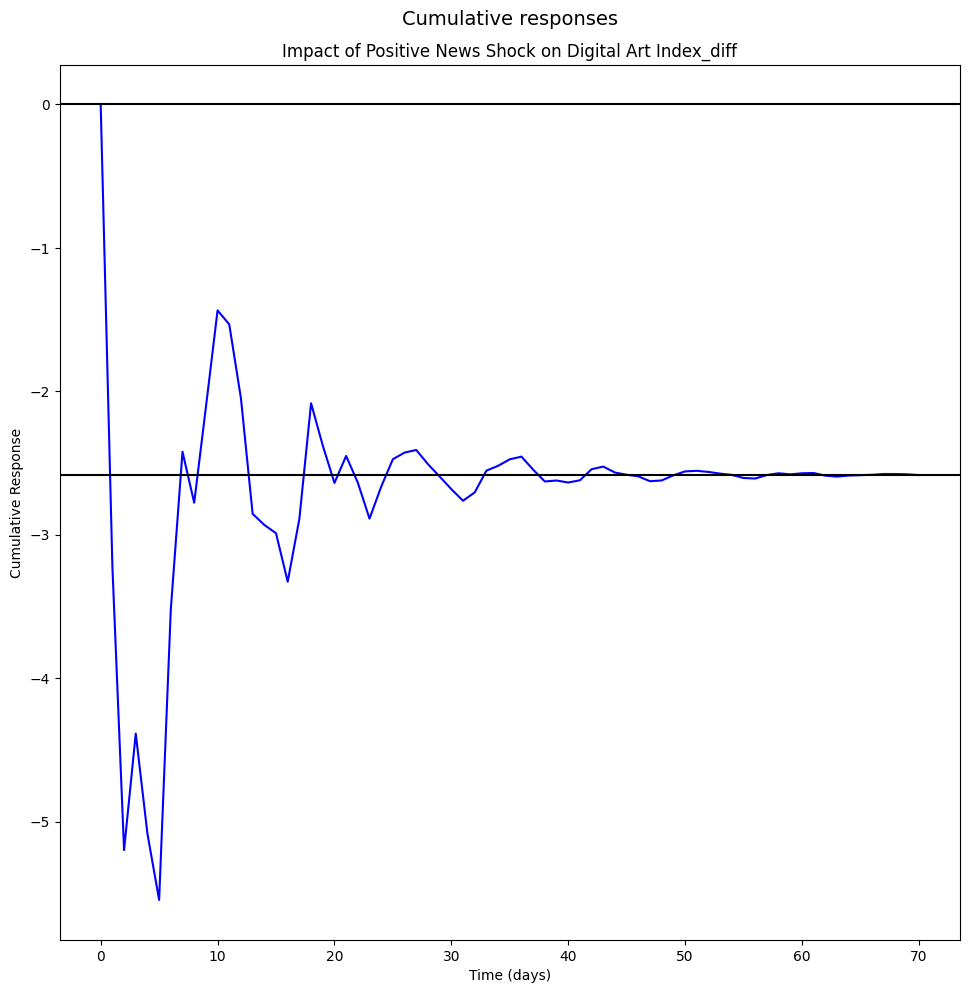

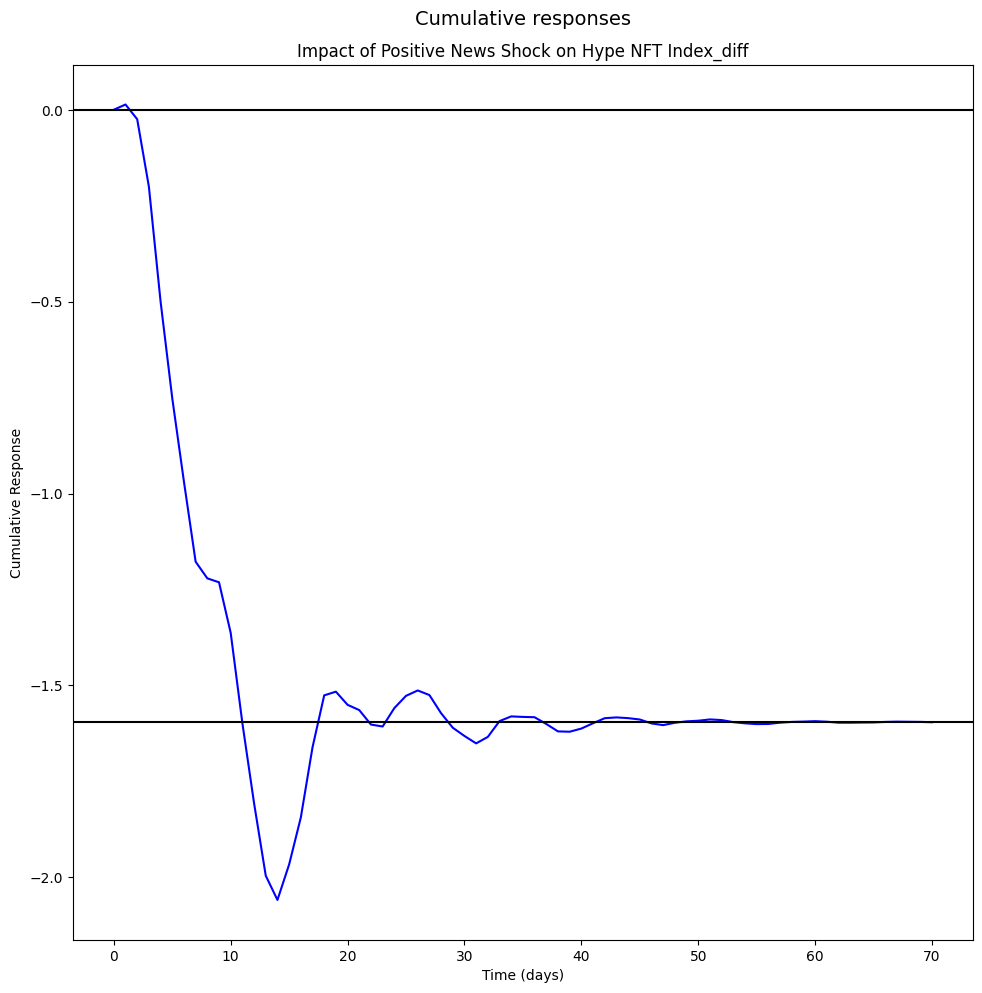

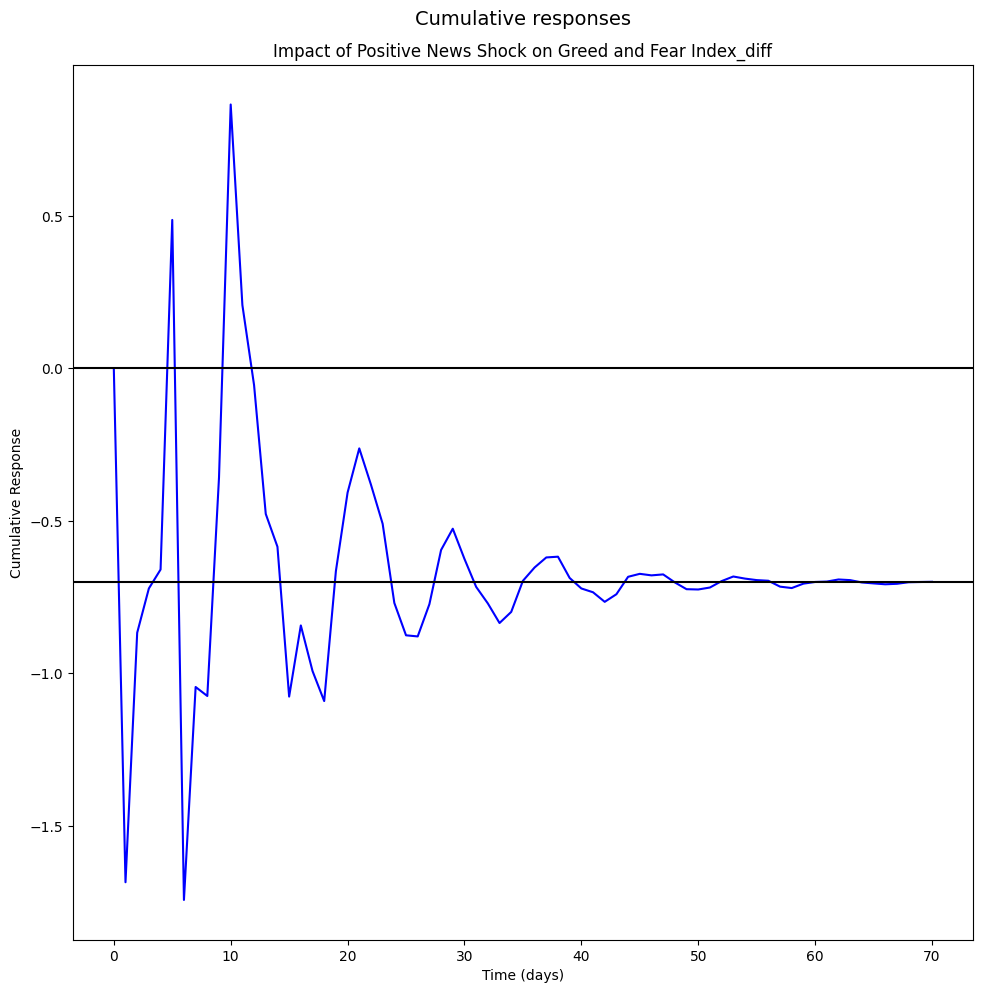

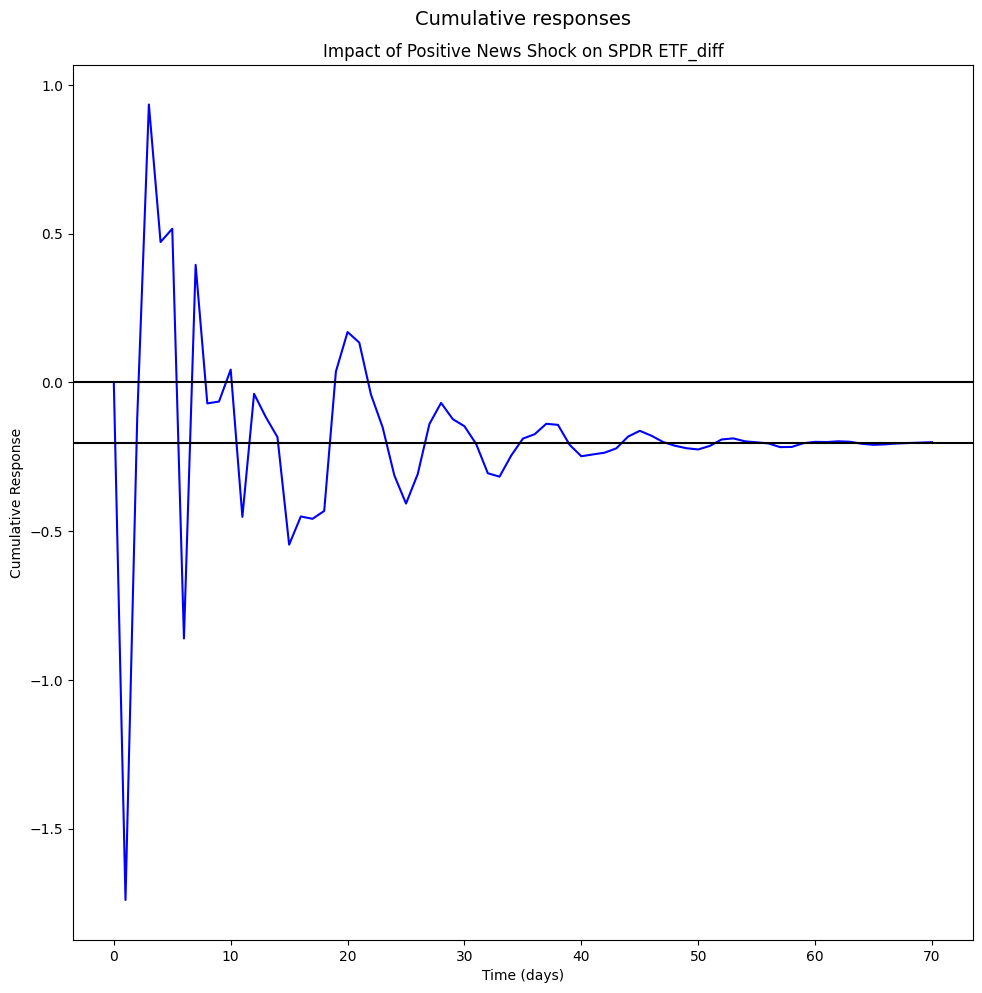

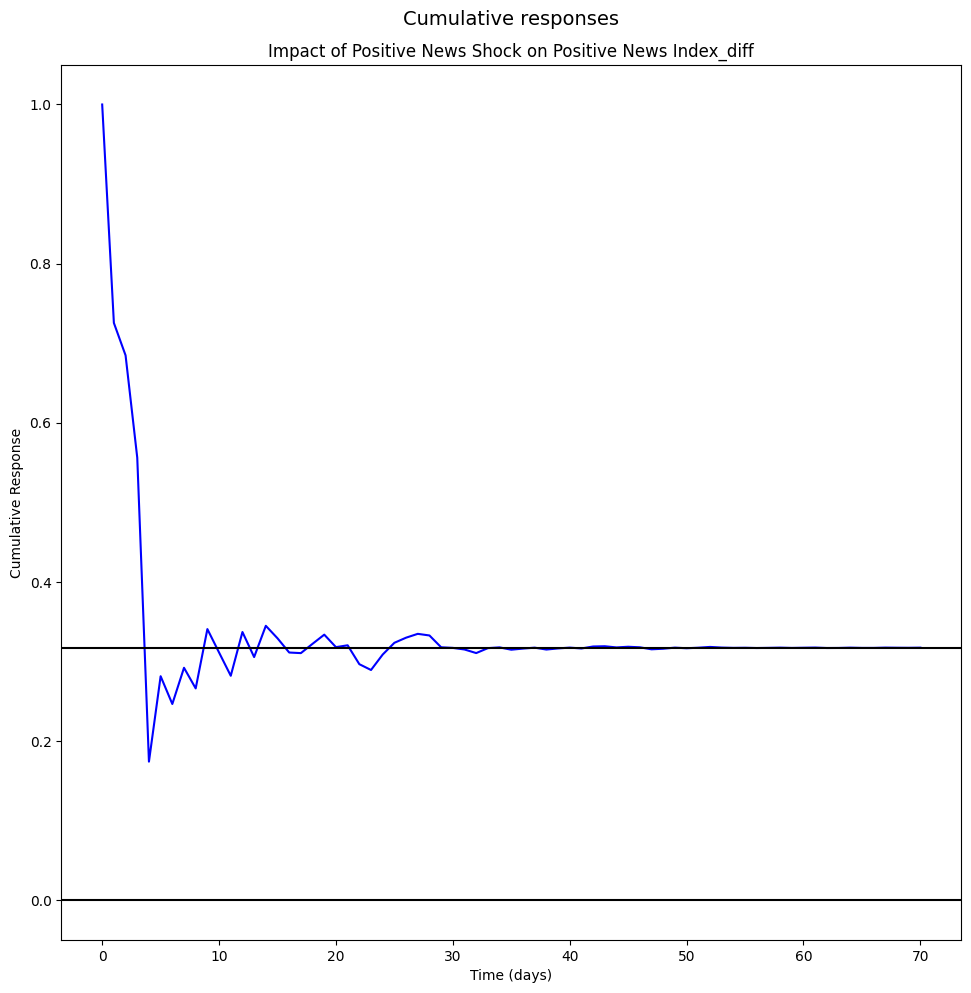

In [90]:
import matplotlib.pyplot as plt


irf = results.irf(70)  # 70 is the number of periods to forecast
positive_news_index = len(data_svar.columns) - 1

for response in range(len(data_svar.columns)):
    irf.plot_cum_effects(impulse=positive_news_index, response=response, plot_stderr=False)
    plt.title(f'Impact of Positive News Shock on {data_svar.columns[response]}')
    plt.xlabel('Time (days)')
    plt.ylabel('Cumulative Response')
    plt.savefig(f'../plots/irf_{data_svar.columns[response]}.png')
